# Step 2: Cell-state classification on predicted malignant cells

This notebook performs the second step of your pipeline:

- Use step-1 zero-shot results to gate cells predicted as malignant only
- Run 3-class zero-shot classification on that malignant subset: `G0_arrested`, `Slow_cycling`, `Fast_cycling`
- Evaluate against available quiescence annotations if present

Reproducibility notes
- We reconstruct the exact dataset ordering used in step 1 via `shuffle(seed=42)` and use stored step-1 predictions to subset.
- We infer which binary prediction index corresponds to "malignant" using similarity to the malignant prompt, avoiding any ambiguity in class order.



In [1]:
# Environment and imports
import os

# Prefer local caches on the cluster
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"]       = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"
os.environ['MPLCONFIGDIR'] = '/cs/student/projects1/aibh/2024/rmaheswa/cache/matplotlib'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_from_disk
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import BertModel as MedBertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification

base_path = '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/ckpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)



/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/venv/lib/python3.13/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda


In [2]:
# Load encoders and heads

class Pooler(nn.Module):
    def __init__(self, config, pretrained_proj, proj_dim):
        super().__init__()
        self.proj = nn.Linear(config.hidden_size, proj_dim)
        self.proj.load_state_dict(torch.load(pretrained_proj))
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        pooled_output = hidden_states[:, 0]
        return F.normalize(self.proj(pooled_output), dim=-1)

# Cell encoder
cell_encoder = BertModel.from_pretrained(
    f'{base_path}/cell_bert',
    local_files_only=True
)
cell_encoder.pooler = Pooler(cell_encoder.config, pretrained_proj=f'{base_path}/cell_proj.bin', proj_dim=256)
cell_encoder = cell_encoder.to(device)

# Text encoder
text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
tokenizer.add_special_tokens({'bos_token': '[DEC]'});
tokenizer.add_special_tokens({'additional_special_tokens': ['[ENC]']});
tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]

text_encoder = MedBertModel.from_pretrained(
    f'{base_path}/text_bert', local_files_only=True, add_pooling_layer=True
)
text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj=f'{base_path}/text_proj.bin', proj_dim=256)
text_encoder = text_encoder.to(device)

# CTM head
ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
ctm_head.load_state_dict(torch.load(f'{base_path}/ctm_head.bin'))
ctm_head = ctm_head.to(device)

cell_encoder.eval(); text_encoder.eval(); ctm_head.eval()
print('Encoders and CTM head loaded.')


Some weights of BertModel were not initialized from the model checkpoint at /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoders and CTM head loaded.


In [3]:
# Helper encode functions (reuse shapes from step 1)

def text_encode(texts):
    toks = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
    out  = text_encoder(**toks)
    return out.pooler_output

@torch.no_grad()
def cell_encode(cell_input_ids, cell_atts):
    out = cell_encoder(input_ids=cell_input_ids.to(device), attention_mask=cell_atts.to(device))
    return out.last_hidden_state, out.pooler_output

@torch.no_grad()
def ctm(texts, cell_emb, cell_atts):
    toks = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
    out  = text_encoder(
        **toks,
        encoder_hidden_states = cell_emb.to(device),
        encoder_attention_mask = cell_atts.to(device),
        return_dict = True,
        mode = 'multimodal',
    )
    logits = ctm_head(out.last_hidden_state[:, 0, :])
    logits = F.softmax(logits, dim=-1)[..., 1]
    return logits


In [4]:
# Recover step-1 predictions and deterministically subset predicted malignant cells

# Load step-1 results (binary)
res_bin = torch.load('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cancer.pt')
cell_embs_bin = res_bin['cell_embs']   # [N, 256]
preds_bin     = res_bin['preds'].long()  # [N]

# Load dataset and reconstruct the same shuffled order used in step 1
all_ds = load_from_disk('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/tokenized_dataset_cancer')
dataset_sub = all_ds.shuffle(seed=42)
assert len(dataset_sub) == preds_bin.shape[0], 'Dataset length differs from predictions; re-run step 1 to regenerate.'

# Build binary text embeddings in a fixed order
cancer_types = ['non-malignant', 'malignant']
with open('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/type2text_cancer.json', 'r') as f:
    type2text_cancer = json.load(f)
texts_bin = [type2text_cancer[t] for t in cancer_types]
with torch.no_grad():
    text_embs_bin = text_encode(texts_bin)   # [2, 256]
    text_embs_bin = text_embs_bin.T.to(device)

# Infer which preds index corresponds to malignant via similarity to the malignant prompt (index 1)
with torch.no_grad():
    sim = (cell_embs_bin.to(device) @ text_embs_bin)  # [N, 2]
    sim_to_malignant = sim[:, 1].cpu()

means = []
for k in [0, 1]:
    means.append(sim_to_malignant[preds_bin == k].mean().item())
malignant_idx = int(torch.tensor(means).argmax().item())
print('Binary class index considered malignant:', malignant_idx)

# Subset dataset rows predicted malignant
malignant_indices = torch.nonzero(preds_bin == malignant_idx, as_tuple=False).squeeze(1).cpu().tolist()
malignant_ds = dataset_sub.select(malignant_indices)
print('Total cells:', len(dataset_sub), 'Predicted malignant:', len(malignant_ds))


Binary class index considered malignant: 1
Total cells: 138727 Predicted malignant: 113332


In [5]:
# Three-class text prompts and embeddings for cell states

# Ensure prompt JSON exists at the path below with the 3 states and descriptions
cellcycle_json = '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/type2text_cellcycle.json'

# Stable order
types3 = ['G0_arrested', 'Slow_cycling', 'Fast_cycling']
with open(cellcycle_json, 'r') as f:
    type2text_cc = json.load(f)
texts3 = [type2text_cc[t] for t in types3]

with torch.no_grad():
    text_embs3 = torch.cat([text_encode([t]) for t in texts3], dim=0).T.to(device)  # [256, 3]
text_embs3.requires_grad = False
print('3-class text embeddings shape:', text_embs3.shape)



3-class text embeddings shape: torch.Size([256, 3])


In [11]:
# Dataloader for malignant subset

# Optional: create labels for evaluation if QuiescenceType/Status is present

def map_quiescence_label(ex):
    # Check QuiescenceStatus first (more reliable)
    qs = (ex.get('QuiescenceStatus', '') or '').strip()
    
    # Map QuiescenceStatus to our three classes
    if qs == 'Quiescent':
        name = 'G0_arrested'
    elif qs == 'Slow-cycling':
        name = 'Slow_cycling'
    elif qs == 'Proliferating':
        name = 'Fast_cycling'
    else:
        # Fallback: try to infer from QuiescenceType if Status is empty
        qt = (ex.get('QuiescenceType', '') or '').strip()
        if qt == 'nan' or qt == '':
            name = None  # No clear mapping
        else:
            # You might want to add more specific mappings here based on your domain knowledge
            name = None
    
    ex['label_name'] = name
    ex['label'] = types3.index(name) if name in types3 else -1
    return ex

malignant_eval = malignant_ds.map(map_quiescence_label)

# Keep only necessary columns for the collator
keep_cols = ['input_ids'] + (['label'] if 'label' in malignant_eval.column_names else [])
drop_cols = [c for c in malignant_eval.column_names if c not in keep_cols]
testdataset = malignant_eval.remove_columns(drop_cols)

batchsize = 48
collator  = DataCollatorForCellClassification()
dataloader = DataLoader(testdataset, batch_size=batchsize, shuffle=False, collate_fn=collator, num_workers=4, pin_memory=True)

batch = next(iter(dataloader))
print(batch.keys(), batch['input_ids'].shape)



Map: 100%|██████████| 113332/113332 [01:57<00:00, 963.14 examples/s]  
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarnin

dict_keys(['input_ids', 'attention_mask', 'labels']) torch.Size([48, 2048])


In [12]:
# Run 3-class zero-shot inference on malignant subset

N = len(testdataset)
C = len(types3)

cell_embs_cc  = torch.zeros(N, 256, device=device)
sim_logits_cc = torch.zeros(N,   C,  device=device)
ctm_logits_cc = torch.zeros(N,   C,  device=device)
logits_cc     = torch.zeros(N,   C,  device=device)
preds_cc      = torch.zeros(N,       device=device, dtype=torch.long)

cell_encoder.eval(); text_encoder.eval(); ctm_head.eval()

with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        cell_last_h, cell_pool = cell_encode(input_ids, attention_mask)
        sim    = (cell_pool @ text_embs3) / 0.05
        sim_lo = F.softmax(sim, dim=-1)

        B = input_ids.size(0)
        ctm_lo = torch.zeros(B, C, device=device)
        for t_idx, ttxt in enumerate(texts3):
            ctm_lo[:, t_idx] = ctm([ttxt] * B, cell_last_h, attention_mask)
        ctm_lo = F.softmax(ctm_lo, dim=-1)

        logit = 0.5 * (sim_lo + ctm_lo)
        pred  = logit.argmax(dim=-1)

        s = batch_idx * batchsize; e = s + B
        sim_logits_cc[s:e] = sim_lo
        ctm_logits_cc[s:e] = ctm_lo
        logits_cc[s:e]     = logit
        cell_embs_cc[s:e]  = cell_pool
        preds_cc[s:e]      = pred

results_cc = {
    'types': types3,
    'texts': texts3,
    'malignant_indices': malignant_indices,
    'malignant_pred_index_in_binary': malignant_idx,
    'cell_embs':  cell_embs_cc.cpu(),
    'sim_logits': sim_logits_cc.cpu(),
    'ctm_logits': ctm_logits_cc.cpu(),
    'logits':     logits_cc.cpu(),
    'preds':      preds_cc.cpu(),
}

out_path = '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cellcycle_from_pred_malignant.pt'
torch.save(results_cc, out_path)
print('Saved 3-class results to:', out_path)



  0%|          | 0/2362 [00:00<?, ?it/s]/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a ten

/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 2362/2362 [54:35<00:00,  1.39s/it]


Saved 3-class results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cellcycle_from_pred_malignant.pt


In [13]:
# Evaluation on malignant subset (if labels exist)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

labels = np.array(malignant_eval['label']) if 'label' in malignant_eval.column_names else None
if labels is None:
    print('No evaluation labels present in malignant subset. Skipping evaluation.')
else:
    preds = results_cc['preds'].numpy()
    mask = labels >= 0
    print('Eval cells with GT in malignant subset:', mask.sum(), '/', len(labels))
    
    if mask.sum() > 0:  # Only proceed if there are valid labels
        print(confusion_matrix(labels[mask], preds[mask]))
        print(classification_report(labels[mask], preds[mask], target_names=results_cc['types'], digits=4))
    else:
        print('No valid labels found for evaluation. All labels are -1.')
        print('Available unique label values:', np.unique(labels))
        print('This suggests the quiescence mapping in map_quiescence_label function may need adjustment.')

Eval cells with GT in malignant subset: 80741 / 113332
[[  440  2918  4812]
 [ 2958 29000 32322]
 [  642  6102  1547]]
              precision    recall  f1-score   support

 G0_arrested     0.1089    0.0539    0.0721      8170
Slow_cycling     0.7628    0.4512    0.5670     64280
Fast_cycling     0.0400    0.1866    0.0659      8291

    accuracy                         0.3838     80741
   macro avg     0.3039    0.2305    0.2350     80741
weighted avg     0.6224    0.3838    0.4654     80741



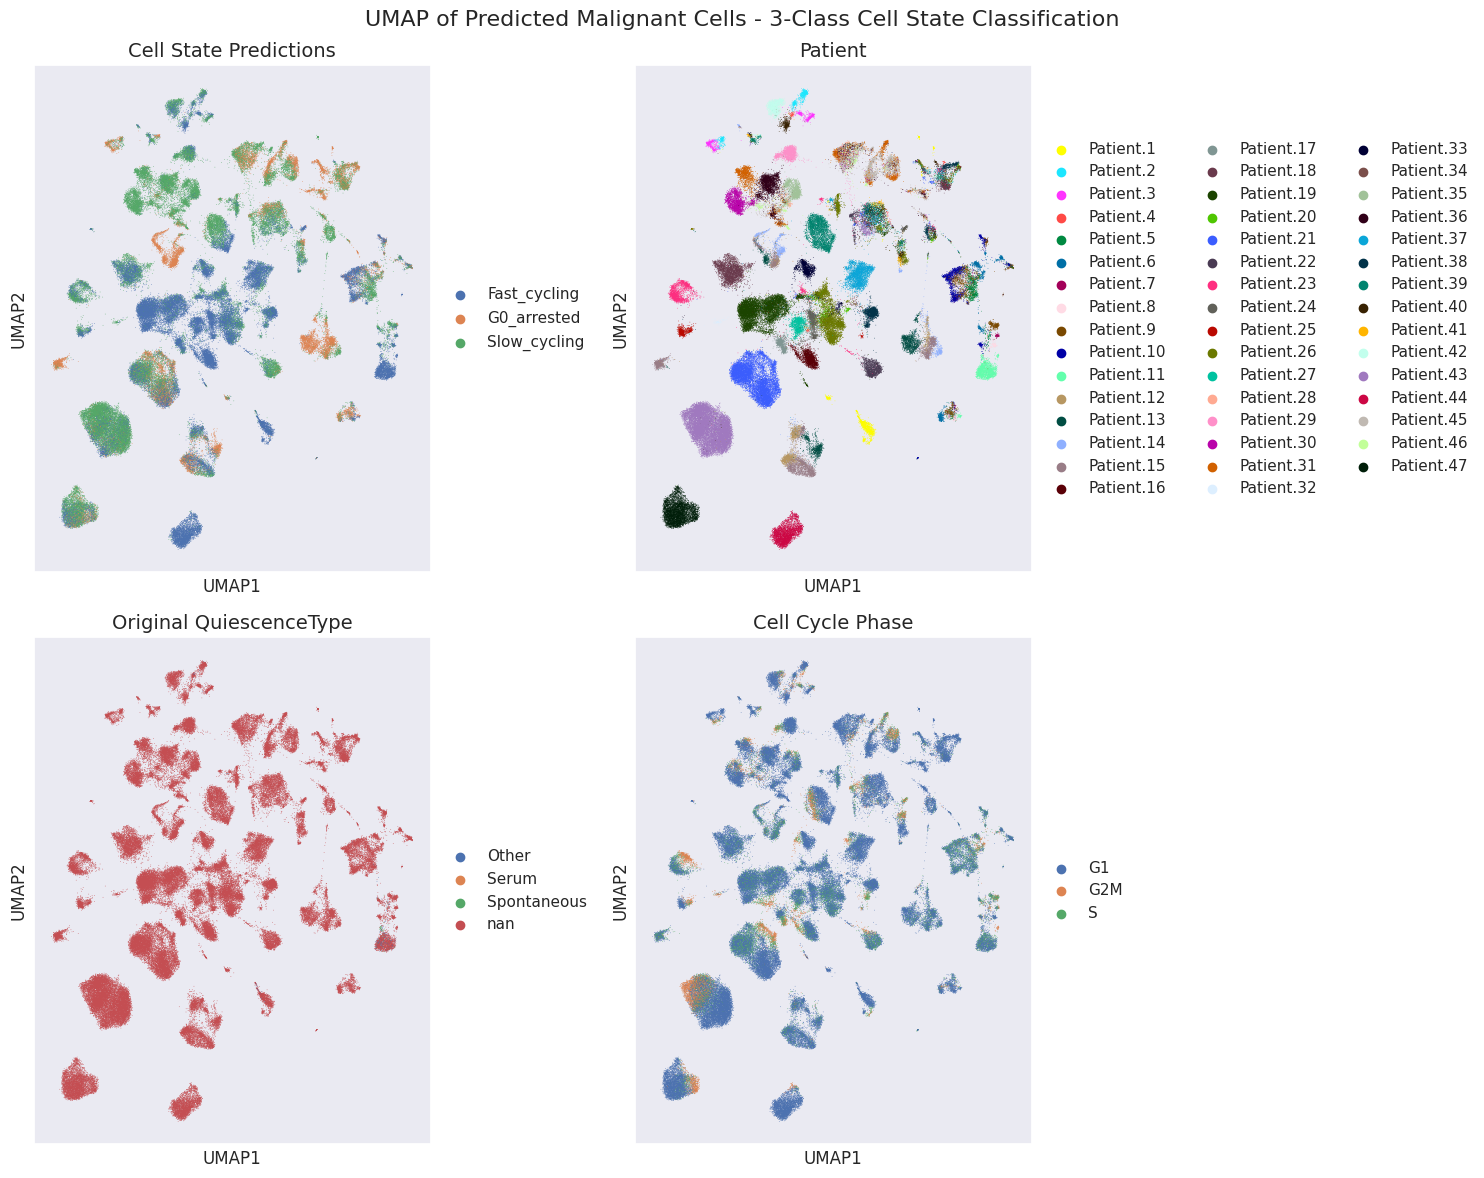


Prediction Distribution:
Slow_cycling: 51305 cells (45.3%)
Fast_cycling: 44879 cells (39.6%)
G0_arrested: 17148 cells (15.1%)

Updated results saved with UMAP coordinates to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cellcycle_from_pred_malignant.pt


In [14]:
# UMAP visualization of 3-class predictions on malignant subset

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

# Create AnnData from cell embeddings
cell_embs = results_cc['cell_embs'].numpy()
cell_embs_ad = ad.AnnData(cell_embs)

# Add metadata
cell_embs_ad.obs['predictions'] = [results_cc['types'][i] for i in results_cc['preds'].numpy()]
cell_embs_ad.obs['malignant_indices'] = results_cc['malignant_indices']

# Add original metadata if available
for col in ['patient', 'disease', 'celltype', 'Phase', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType']:
    if col in malignant_ds.column_names:
        cell_embs_ad.obs[col] = malignant_ds[col]

# Compute neighbors and UMAP
sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=30)
sc.tl.umap(cell_embs_ad, random_state=42)

# Plot UMAP colored by predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('UMAP of Predicted Malignant Cells - 3-Class Cell State Classification', fontsize=16)

# Main prediction plot
sc.pl.umap(cell_embs_ad, color='predictions', ax=axes[0,0], show=False, 
           title='Cell State Predictions', legend_loc='right margin')
axes[0,0].set_title('Cell State Predictions', fontsize=14)

# Patient/disease if available
if 'patient' in cell_embs_ad.obs.columns:
    sc.pl.umap(cell_embs_ad, color='patient', ax=axes[0,1], show=False, 
               title='Patient', legend_loc='right margin')
    axes[0,1].set_title('Patient', fontsize=14)

# Original quiescence info if available
if 'QuiescenceType' in cell_embs_ad.obs.columns:
    sc.pl.umap(cell_embs_ad, color='QuiescenceType', ax=axes[1,0], show=False, 
               title='Original QuiescenceType', legend_loc='right margin')
    axes[1,0].set_title('Original QuiescenceType', fontsize=14)

# Cell cycle phase if available
if 'Phase' in cell_embs_ad.obs.columns:
    sc.pl.umap(cell_embs_ad, color='Phase', ax=axes[1,1], show=False, 
               title='Cell Cycle Phase', legend_loc='right margin')
    axes[1,1].set_title('Cell Cycle Phase', fontsize=14)

plt.tight_layout()
plt.show()

# Print prediction distribution
print("\nPrediction Distribution:")
pred_counts = cell_embs_ad.obs['predictions'].value_counts()
for pred, count in pred_counts.items():
    print(f"{pred}: {count} cells ({count/len(cell_embs_ad)*100:.1f}%)")

# Save UMAP coordinates for later use
umap_coords = cell_embs_ad.obsm['X_umap']
results_cc['umap_coords'] = torch.tensor(umap_coords)
torch.save(results_cc, out_path)  # Update saved results with UMAP
print(f"\nUpdated results saved with UMAP coordinates to: {out_path}")

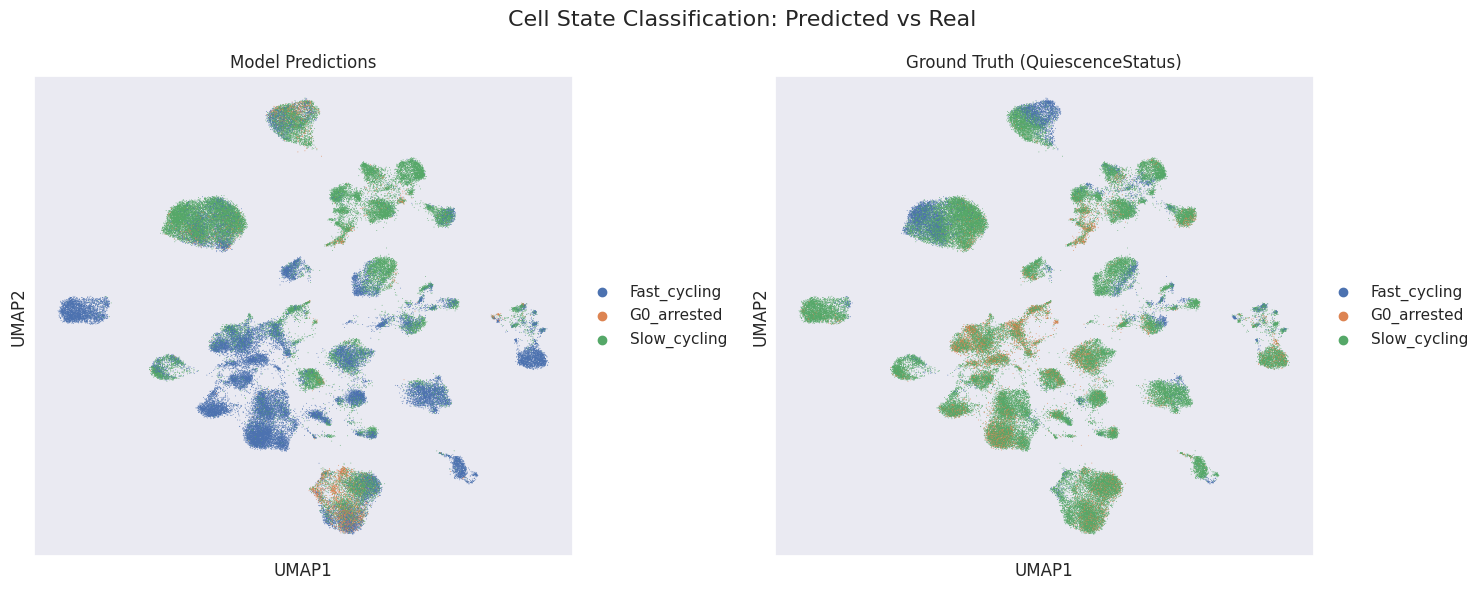


Prediction vs Ground Truth Comparison:
              precision    recall  f1-score   support

 G0_arrested     0.1089    0.0539    0.0721      8170
Slow_cycling     0.7628    0.4512    0.5670     64280
Fast_cycling     0.0400    0.1866    0.0659      8291

    accuracy                         0.3838     80741
   macro avg     0.3039    0.2305    0.2350     80741
weighted avg     0.6224    0.3838    0.4654     80741



In [15]:
# UMAP visualization: Predicted vs Real cell states only
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

# Create AnnData from cell embeddings
cell_embs = results_cc['cell_embs'].numpy()
cell_embs_ad = ad.AnnData(cell_embs)

# Add predictions
cell_embs_ad.obs['predictions'] = [results_cc['types'][i] for i in results_cc['preds'].numpy()]

# Add real labels (ground truth)
if 'label' in malignant_eval.column_names:
    labels = np.array(malignant_eval['label'])
    mask = labels >= 0
    if mask.sum() > 0:
        # Only show cells with valid ground truth labels
        cell_embs_ad = cell_embs_ad[mask].copy()
        cell_embs_ad.obs['real_states'] = [results_cc['types'][i] if i >= 0 else 'Unknown' for i in labels[mask]]
    else:
        print("No valid ground truth labels found for visualization")
        cell_embs_ad = None

if cell_embs_ad is not None:
    # Compute neighbors and UMAP
    sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=30)
    sc.tl.umap(cell_embs_ad, random_state=42)
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Cell State Classification: Predicted vs Real', fontsize=16)
    
    # Left plot: Model predictions
    sc.pl.umap(cell_embs_ad, color='predictions', ax=axes[0], show=False, 
               title='Model Predictions', legend_loc='right margin')
    
    # Right plot: Ground truth
    sc.pl.umap(cell_embs_ad, color='real_states', ax=axes[1], show=False, 
               title='Ground Truth (QuiescenceStatus)', legend_loc='right margin')
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction vs ground truth comparison
    print("\nPrediction vs Ground Truth Comparison:")
    from sklearn.metrics import classification_report
    preds_filtered = results_cc['preds'][mask].numpy()
    labels_filtered = labels[mask]
    print(classification_report(labels_filtered, preds_filtered, 
                              target_names=results_cc['types'], digits=4))
else:
    print("Cannot create visualization without valid ground truth labels")